In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
import datetime
import sys
sys.path.append('..')
import src.tools as tools

#RFM Libraries
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from scipy.stats import kruskal
from sklearn.decomposition import PCA
from datetime import datetime, timedelta,date
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

In [2]:
a = pd.read_csv('../data/Year 2009-2010.csv', encoding='unicode_escape')
b = pd.read_csv('../data/Year 2010-2011.csv', encoding='unicode_escape')
retail = pd.concat([a,b], ignore_index=True)

Prepare dataframe

In [3]:
retail.columns= retail.columns.str.lower()
retail.drop_duplicates(inplace=True)
retail = retail.query("country=='United Kingdom'").reset_index(drop=True)
retail.invoicedate = pd.to_datetime(retail.invoicedate)
retail['year'] = retail.invoicedate.dt.year
retail['month'] = retail.invoicedate.dt.month
retail['week'] = retail.invoicedate.dt.isocalendar().week
retail['day'] = retail.invoicedate.dt.day
retail['hour'] = retail.invoicedate.dt.hour
retail['revenue'] = retail.price * retail.quantity
#retail = retail.query("year>2009").reset_index(drop=True)
retail = retail.query("quantity>0").reset_index(drop=True)
retail = retail.query("price>0").reset_index(drop=True)
retail = retail.dropna()

Define customers

In [4]:
min_date = retail.groupby(['customer id'])['invoicedate'].min().reset_index()
max_date = retail.groupby(['customer id'])['invoicedate'].max().reset_index()
min_date.columns = ['customer id', 'min_date']
max_date.columns = ['customer id', 'max_date']
min_date = pd.merge(min_date, max_date, on='customer id')
min_date['customer_months'] = min_date['max_date'] - min_date['min_date']
min_date['customer_months'] = min_date['customer_months'] / np.timedelta64(1,'M')
min_date['customer_months'] = min_date['customer_months'].astype(int)
min_date.drop(columns=['min_date','max_date'], inplace=True)
retail = pd.merge(retail, min_date, on='customer id')
retail.sample()

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country,year,month,week,day,hour,revenue,customer_months
583386,567128,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2011-09-16 14:04:00,4.25,18055.0,United Kingdom,2011,9,37,16,14,25.5,13


### OVERVIEW

In [5]:
total = retail.groupby('year')['quantity','revenue'].sum().transpose()
total['%Δ'] = (total[2011] / total[2010] -1)*100
total

/var/folders/xv/v29gqxhs4b5gth_lvdz9tgl80000gn/T/ipykernel_2629/429543714.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total = retail.groupby('year')['quantity','revenue'].sum().transpose()


year,2009,2010,2011,%Δ
quantity,360350.00,4197329.000,3974732.000,-5.303301
revenue,610346.63,6990340.983,6788547.304,-2.886750


### TRENDS

In [6]:
retail_lines = retail[['invoicedate','quantity','revenue']]
retail_lines.sample()

,invoicedate,quantity,revenue
586893,2011-02-17 13:28:00,4,11.8


In [7]:
retail_lines.invoicedate = pd.to_datetime(retail_lines.invoicedate).dt.strftime('%Y-%m')
retail_lines = retail_lines.groupby('invoicedate')['quantity','revenue'].sum().reset_index()
retail_lines['item_price'] = retail_lines.revenue / retail_lines.quantity

/opt/homebrew/Caskroom/miniconda/base/envs/ironhack/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/var/folders/xv/v29gqxhs4b5gth_lvdz9tgl80000gn/T/ipykernel_2629/148635078.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  retail_lines = retail_lines.groupby('invoicedate')['quantity','revenue'].sum().reset_index()


In [8]:
retail_lines['qty_indx'] = retail_lines.quantity / retail_lines.quantity[0]
retail_lines['rev_indx'] = retail_lines.revenue / retail_lines.revenue[0]
retail_lines['itemprice_indx'] = retail_lines.item_price / retail_lines.item_price[0]

In [9]:
retail_lines.head()

,invoicedate,quantity,revenue,item_price,qty_indx,rev_indx,itemprice_indx
0,2009-12,360350,610346.630,1.693761,1.000000,1.000000,1.000000
1,2010-01,236118,415120.502,1.758106,0.655246,0.680139,1.037990
2,2010-02,234173,409265.826,1.747707,0.649849,0.670547,1.031850
3,2010-03,384039,587165.941,1.528923,1.065739,0.962020,0.902679
4,2010-04,290254,500798.551,1.725380,0.805478,0.820515,1.018668


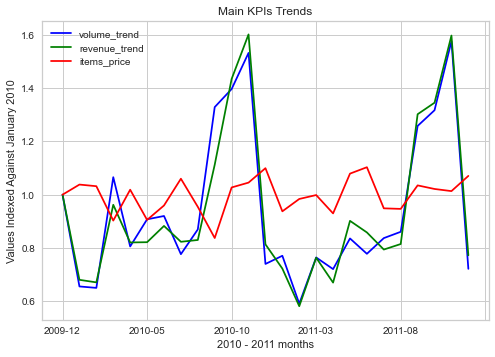

In [10]:
retail_lines.groupby('invoicedate')['qty_indx'].sum().plot(label='volume_trend', color='Blue')
retail_lines.groupby('invoicedate')['rev_indx'].sum().plot(label='revenue_trend', color='Green')
retail_lines.groupby('invoicedate')['itemprice_indx'].sum().plot(label='items_price', color='Red')

plt.title('Main KPIs Trends')
plt.xlabel('2010 - 2011 months')
plt.ylabel('Values Indexed Against January 2010')

plt.legend()
plt.show()

### SEGMENTATION

In [11]:
(retail.customer_months.value_counts(normalize=True)*100).sort_index()

0      5.924573
1      1.657938
2      1.658938
3      1.936355
4      1.731326
5      1.252020
6      1.343684
7      1.658367
8      1.966767
9      1.457335
10     1.591118
11     2.834143
12     3.810174
13     3.471504
14     2.956219
15     2.288731
16     3.080150
17     3.271615
18     3.580158
19     5.148575
20     6.626042
21     5.734393
22     6.366043
23    18.780590
24     9.873242
Name: customer_months, dtype: float64

#### RFM

Customers for RFM

In [12]:
retail_23 = retail.query('customer_months>=12').reset_index(drop=True)
df_2y = tools.rfm(retail_23)
df_2y.head()

,customer id,recency,frequency,monetary
0,13085.0,157,84,2433.28
1,13078.0,2,791,29018.06
2,18102.0,0,1040,580987.04
3,18087.0,97,88,14761.52
4,13635.0,67,162,2999.16


Drop outliers

In [13]:
df_2y['z_recency'] = stats.zscore(df_2y.recency)
df_2y['z_frequency'] = stats.zscore(df_2y.frequency)
df_2y['z_monetary'] = stats.zscore(df_2y.monetary)

df_2y.drop(columns='customer id').describe()

,recency,frequency,monetary,z_recency,z_frequency,z_monetary
count,2082.000000,2082.000000,2082.000000,2.082000e+03,2.082000e+03,2.082000e+03
mean,63.358309,252.258886,5457.522403,2.047674e-17,-2.730231e-17,2.730231e-17
std,73.419057,451.926573,17789.796496,1.000240e+00,1.000240e+00,1.000240e+00
min,0.000000,2.000000,30.950000,-8.631755e-01,-5.538931e-01,-3.051118e-01
25%,12.000000,68.000000,1170.375000,-6.996909e-01,-4.078166e-01,-2.410470e-01
50%,33.000000,144.000000,2416.900000,-4.135929e-01,-2.396073e-01,-1.709605e-01
75%,84.000000,292.000000,4868.005000,2.812165e-01,8.795823e-02,-3.314591e-02
max,366.000000,12435.000000,580987.040000,4.123104e+00,2.696382e+01,3.235944e+01


In [14]:
df_2y = df_2y[(df_2y.z_recency >= -2) & (df_2y.z_recency <= 2) &
         (df_2y.z_frequency >= -2) & (df_2y.z_frequency <= 2) &
         (df_2y.z_monetary >= -2) & (df_2y.z_monetary <= 2)]

df_2y.drop(columns='customer id').describe()

,recency,frequency,monetary,z_recency,z_frequency,z_monetary
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,50.067374,216.230239,3975.556976,-0.181072,-0.079741,-0.083324
std,50.605351,211.867550,4737.391875,0.689433,0.468922,0.266362
min,0.000000,2.000000,30.950000,-0.863175,-0.553893,-0.305112
25%,12.000000,70.000000,1188.420000,-0.699691,-0.403390,-0.240032
50%,31.000000,145.000000,2437.050000,-0.440840,-0.237394,-0.169828
75%,71.000000,286.000000,4685.720000,0.104108,0.074679,-0.043395
max,210.000000,1152.000000,39019.510000,1.997804,1.991379,1.887040


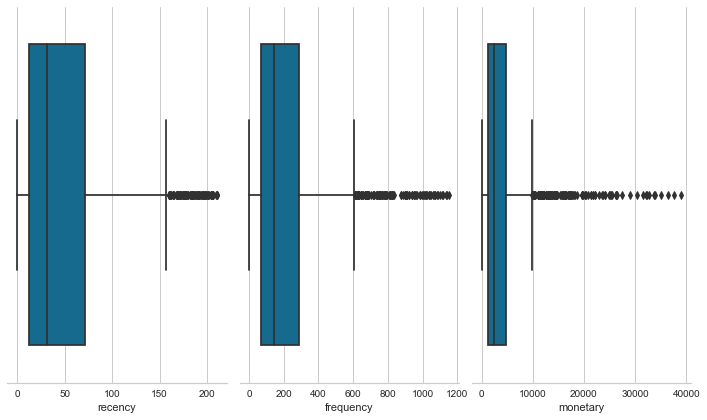

In [15]:
f, axes = plt.subplots(1, 3, figsize=(10, 6))
sns.despine(left=True)

sns.boxplot(x=df_2y.recency, color="b", ax=axes[0])
sns.boxplot(x=df_2y.frequency, color="b", ax=axes[1])
sns.boxplot(x=df_2y.monetary, color="b",ax=axes[2])

plt.tight_layout();

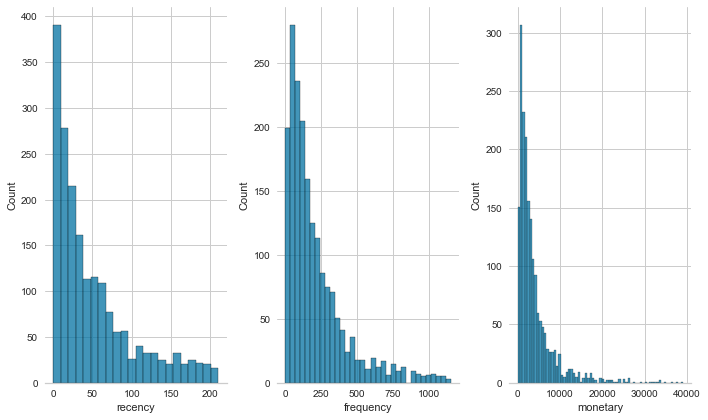

In [16]:
f, axes = plt.subplots(1, 3, figsize=(10, 6))
sns.despine(left=True)

sns.histplot(df_2y.recency, color="b", ax=axes[0])
sns.histplot(df_2y.frequency, color="b", ax=axes[1])
sns.histplot(df_2y.monetary, color="b",ax=axes[2])

plt.tight_layout();

In [17]:
print(stats.jarque_bera(df_2y.recency)[1] < 0.05)
print(stats.jarque_bera(df_2y.frequency)[1] < 0.05)
print(stats.jarque_bera(df_2y.monetary)[1] < 0.05)

True
True
True


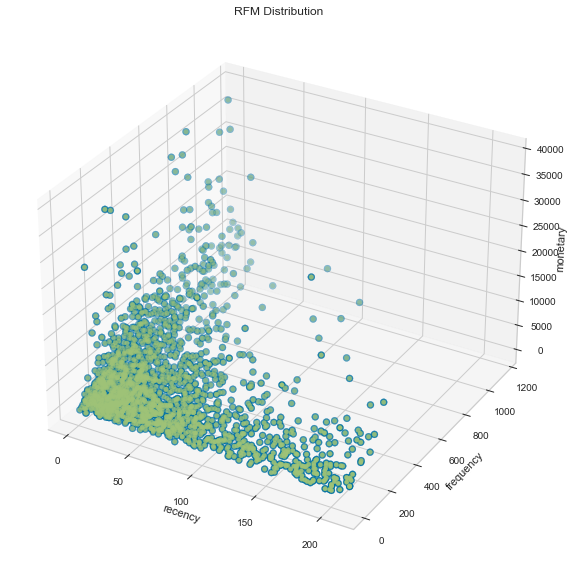

In [18]:
fig = plt.figure()

fig.set_size_inches(10, 10)

ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(df_2y.recency, df_2y.frequency, df_2y.monetary, s=50)

ax.set_title("RFM Distribution")
ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("monetary")

ax.scatter(df_2y.recency,df_2y.frequency,df_2y.monetary)

colormap='Blues'

#ax.grid(False)


plt.show()

Elbow method to define K means

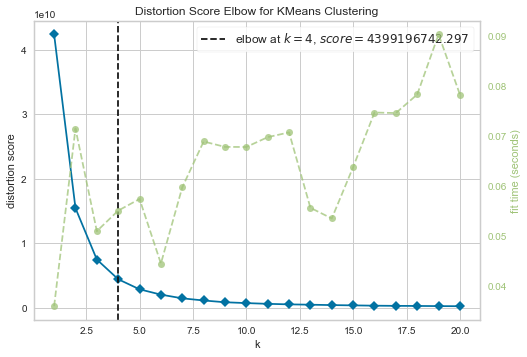

In [19]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,21))

visualizer.fit(df_2y[['recency', 'frequency', 'monetary']])
visualizer.show();

Kmeans analysis

In [20]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_2y[['recency', 'frequency', 'monetary']])
df_2y['clusters'] = kmeans.predict(df_2y[['recency', 'frequency', 'monetary']])
df_2y.sample(3)

,customer id,recency,frequency,monetary,z_recency,z_frequency,z_monetary,clusters
295,14896.0,204,253,1826.00,1.916062,0.001640,-0.204184,0
1481,16767.0,30,321,8056.76,-0.454464,0.152143,0.146143,3
2034,17702.0,29,153,3144.04,-0.468088,-0.219688,-0.130077,0


In [21]:
(df_2y.clusters.value_counts(normalize=True)*100).sort_index()

0    70.344828
1     5.358090
2     1.697613
3    22.599469
Name: clusters, dtype: float64

In [22]:
df_2y.drop(columns='customer id').groupby(['clusters']).median()

,recency,frequency,monetary,z_recency,z_frequency,z_monetary
clusters,,,,,,
0,40.0,105.0,1667.845,-0.318227,-0.325925,-0.213077
1,11.0,403.0,14000.850,-0.713315,0.333632,0.480353
2,3.5,616.0,26268.985,-0.815492,0.805061,1.170135
3,21.0,310.5,6082.845,-0.577077,0.128904,0.035159


In [23]:
weighted = df_2y.drop(columns='customer id').groupby(['clusters']).median()
weighted['recency'] = weighted['recency']/weighted['recency'].min()
weighted['frequency'] = weighted['frequency']/weighted['frequency'].max()
weighted['monetary'] = weighted['monetary']/weighted['monetary'].max()
weighted['segment'] = (weighted.frequency * weighted.monetary) / weighted.recency
weighted['segment'] = weighted.segment.rank(ascending=False)
weighted.sort_values(by='segment')

,recency,frequency,monetary,z_recency,z_frequency,z_monetary,segment
clusters,,,,,,,
2,1.000000,1.000000,1.000000,-0.815492,0.805061,1.170135,1.0
1,3.142857,0.654221,0.532980,-0.713315,0.333632,0.480353,2.0
3,6.000000,0.504058,0.231560,-0.577077,0.128904,0.035159,3.0
0,11.428571,0.170455,0.063491,-0.318227,-0.325925,-0.213077,4.0


In [24]:
df_2y = pd.merge(df_2y, weighted['segment'], on='clusters')
df_2y.sample(3)

,customer id,recency,frequency,monetary,z_recency,z_frequency,z_monetary,clusters,segment
323,16841.0,36,219,4006.06,-0.372722,-0.073611,-0.081609,0,4.0
1463,13394.0,1,409,6621.70,-0.849552,0.346912,0.065456,3,3.0
948,14498.0,42,369,3900.83,-0.290980,0.258381,-0.087526,0,4.0


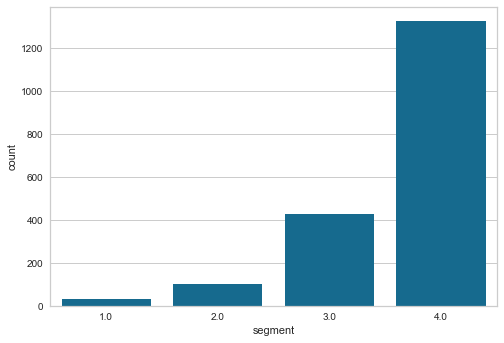

In [25]:
sns.countplot(x=df_2y.segment, color="b");

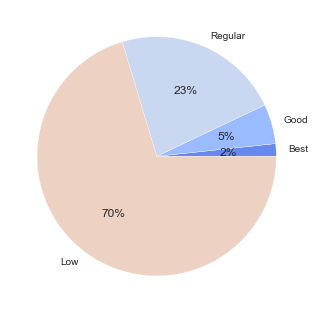

In [73]:
colors = sns.color_palette('coolwarm')[0:5]

plt.pie((df_2y.segment.value_counts(normalize=True)*100).sort_index(ascending=True), autopct='%.0f%%', 
        labels=['Best','Good','Regular','Low'],
       colors=colors)

plt.show();

In [27]:
y = pd.DataFrame(df_2y.groupby('segment')['customer id'].count()).reset_index()
y

,segment,customer id
0,1.0,32
1,2.0,101
2,3.0,426
3,4.0,1326


In [28]:
x = pd.DataFrame(df_2y.groupby('segment')['recency','frequency','monetary'].median().astype(int)).reset_index()
x.segment.replace({1:'Best',2:'Good',3:'Regular',4:'Low'},inplace=True)

/var/folders/xv/v29gqxhs4b5gth_lvdz9tgl80000gn/T/ipykernel_2629/722221762.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  x = pd.DataFrame(df_2y.groupby('segment')['recency','frequency','monetary'].median().astype(int)).reset_index()


In [29]:
x.set_index('segment')

,recency,frequency,monetary
segment,,,
Best,3,616,26268
Good,11,403,14000
Regular,21,310,6082
Low,40,105,1667


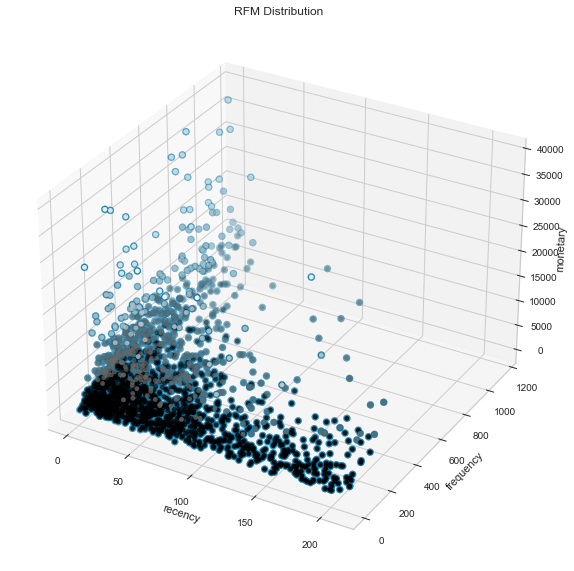

In [30]:
fig = plt.figure()

fig.set_size_inches(10, 10)

ax = fig.add_subplot(111, projection='3d')
cax = ax.scatter(df_2y.recency, df_2y.frequency, df_2y.monetary, s=50)

ax.set_title("RFM Distribution")
ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("monetary")

ax.scatter(df_2y.recency,df_2y.frequency,df_2y.monetary, c=df_2y.segment, )

colormap='Blues'

#ax.grid(False)


plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/ironhack/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


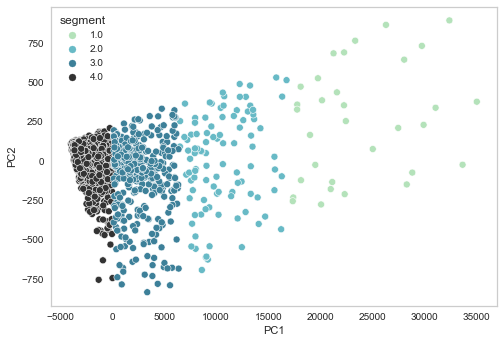

In [31]:
pca = PCA(2)
data_t = pd.DataFrame(pca.fit_transform(df_2y.drop(columns='customer id')), columns=["PC1", "PC2"])

sns.set_style("whitegrid", {'axes.grid' : False})

sns.scatterplot(data_t["PC1"],data_t["PC2"], hue=df_2y['segment'], palette='GnBu_d');

In [32]:
retail2y = pd.merge(retail_23, df_2y[['customer id', 'segment']], on='customer id')
retail2y.sample(3)

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country,year,month,week,day,hour,revenue,customer_months,segment
320022,530409,22690,DOORMAT HOME SWEET HOME BLUE,2,2010-11-02 18:08:00,7.95,16614.0,United Kingdom,2010,11,44,2,18,15.90,13,4.0
270010,535318,22476,EMPIRE UNION JACK TV DINNER TRAY,1,2010-11-25 15:01:00,4.95,13573.0,United Kingdom,2010,11,47,25,15,4.95,19,4.0
289184,560385,23094,LE GRAND TRAY CHIC SET,2,2011-07-18 12:53:00,12.50,14583.0,United Kingdom,2011,7,29,18,12,25.00,20,4.0


Forecast customers behavior

In [33]:
#retail2y.groupby(['year','month','segment'])['revenue'].sum().unstack().fillna(0)

Time series

In [34]:
retail2y.invoicedate = pd.to_datetime(retail2y.invoicedate).dt.normalize()

cluster1 = retail2y[retail2y.segment == 1]
cluster1 = cluster1[['invoicedate', 'revenue']]

cluster2 = retail2y[retail2y.segment == 2]
cluster2 = cluster2[['invoicedate', 'revenue']]

cluster3 = retail2y[retail2y.segment == 3]
cluster3 = cluster3[['invoicedate', 'revenue']]

cluster4 = retail2y[retail2y.segment == 4]
cluster4 = cluster4[['invoicedate', 'revenue']]

In [76]:
cluster1

,invoicedate,revenue
84,2009-12-01,59.50
85,2009-12-01,98.10
86,2009-12-01,17.85
87,2009-12-01,27.04
88,2009-12-01,20.85
...,...,...
383541,2011-12-08,20.85
383542,2011-12-08,23.80
383543,2011-12-08,11.70
383544,2011-12-08,23.80


In [75]:
"""retail2y.invoicedate = pd.to_datetime(retail2y.invoicedate).dt.normalize()

cluster11 = retail2y[retail2y.segment == 1]
cluster11 = cluster11[['invoicedate', 'quantity']]

cluster22 = retail2y[retail2y.segment == 2]
cluster22 = cluster22[['invoicedate', 'quantity']]

cluster33 = retail2y[retail2y.segment == 3]
cluster33 = cluster33[['invoicedate', 'quantity']]

cluster44 = retail2y[retail2y.segment == 4]
cluster44 = cluster44[['invoicedate', 'quantity']]""";

In [ ]:
retail_lines['qty_indx'] = retail_lines.quantity / retail_lines.quantity[0]
retail_lines['rev_indx'] = retail_lines.revenue / retail_lines.revenue[0]
retail_lines['itemprice_indx'] = retail_lines.item_price / retail_lines.item_price[0]

In [ ]:
retail_lines.groupby('invoicedate')['qty_indx'].sum().plot(label='volume_trend', color='Blue')
retail_lines.groupby('invoicedate')['rev_indx'].sum().plot(label='revenue_trend', color='Green')
retail_lines.groupby('invoicedate')['itemprice_indx'].sum().plot(label='items_price', color='Red')

plt.title('Main KPIs Trends')
plt.xlabel('2010 - 2011 months')
plt.ylabel('Values Indexed Against January 2010')

plt.legend()
plt.show()

def clean_ts (df):
    df.columns = ['ds','y']
    df.ds = pd.to_datetime(df.ds).dt.strftime('%Y-%m')
    #df['z_score'] = stats.zscore(df.y)
    #df = df[(df.z_score >= -3) & (df.z_score <= 3)]
    #df = df.drop(columns='z_score')"""
    df.set_index('ds', inplace=True)
    return df

Export

In [63]:
"""cluster1.to_csv('../data/ts_segment1.csv',index=False)
cluster2.to_csv('../data/ts_segment2.csv',index=False)
cluster3.to_csv('../data/ts_segment3.csv',index=False)
cluster4.to_csv('../data/ts_segment4.csv',index=False)""";

In [64]:
"""cluster11.to_csv('../data/ts_segment11.csv',index=False)
cluster22.to_csv('../data/ts_segment22.csv',index=False)
cluster33.to_csv('../data/ts_segment33.csv',index=False)
cluster44.to_csv('../data/ts_segment44.csv',index=False)""";